# GP 教程-E02: 一小时上手的简单GP
作者: Wei W. Xing (wxing.me) <br />
翻译: Yuxin Wang
日期: 2022-03-28    <br />

摘要: 现如今高斯过程已经是一个长期存在并且广泛被应用的技术，并且也有很多有用的教程、课本、文章以及博客，但是我发现很多学生（包括学生时代的我）都曾经在将GP应用到实际问题这个过程中碰壁。我认为学会一个东西最简单的方法就是应用它而不是准备很多必要的数学背景或者深入理论。因此我准写了这篇教程，希望可以用一种比较直接的方式来应用GP这个技术，尤其是为了工科的学生们。希望这篇教程能有所帮助。

在这篇教程中，我们希望可以考虑最简单的一维输出的例子，也就是，$y \in \mathcal{R}^1$，是一维标量。相对应的
$\mathcal{x} \in \mathcal{R}^D$，输入的是一个D维的向量。
那么让我们开始吧～ 由于这篇应用是基于Torch开发的，所以我们将从导入Torch库作为开端。

In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import os
# from torch.autograd import Variable

print(torch.__version__)
# I use torch (1.11.0) for this work. lower version may not work.

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS 

JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

2.0.1+cu118


#### 1. 生成综合数据
将$y = (6x-2)^2sin(12x-4)$作为我们的目标拟合函数。我们将需要产生包含32组样本点的训练数据集$xtr, ytr$ 以及包含100组数据的测试数据集$xte, yte$ 。

xtr.size: torch.Size([32, 1]) ytr.size: torch.Size([32, 1])
xte.size: torch.Size([100, 1]) yte.size: torch.Size([100, 1])


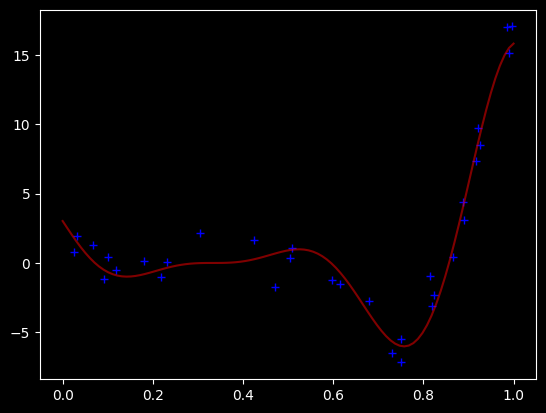

In [2]:
#train_set
xtr = torch.rand(32, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(32, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
plt.show()

#### 2. 核函数以及模型参数（超参数）

我们需要优化的函数是：均值函数以及核函数。但是优化一个“函数”并不是就想所说的那么简单， 因此我们需要给丁这些函数的特定形式，之后再去优化他们的参数。在这篇教程中，我们设定均值函数为零（不需要优化均值函数）。而核函数部分，我们使用最常用的automatic relevance determinant（ARD）核函数：
$$k_{ard}(\mathbf{x}, \mathbf{x}') = a \cdot \exp(-\frac{1}{2} \sum_{d=1}^D{ (\frac{x_d-x'_d}{l_d}})^2 )$$
其中$a$是核函数的振幅，$l_d$是输入变量$x$的d维输入${x}_d$的长度系数（length scale）。$\mathbf{l}$ 控制着每个输入维度的贡献量，比如：$l_d$数值越大，则${x}_d$相比于其他维度在系统中的贡献越大；反之亦然。因此，这个函数被称为ARD，即可以自动控制相关性。 <br />

在开始编程之前还有另一件事情需要注意，$l_d$和$a$均为正参数。所以如果我们直接将他们定义为torch中的参数torch.parameters，则在优化过程中有可能导致$l_d$和$a$被计算成负数。因此我们需要特别注意确保$l_d$和$a$在过程中为正数。一个简单的方法就是，用他们取log之后的值来定义，而使用的时候再将其转换为其指数值。 <br />

 那么现在我们可以定义核函数了，其返回值为输入两组数据的一个核矩阵。

In [3]:
# define kernel parameters
log_length_scale = nn.Parameter(torch.zeros(xte.size(1)))
log_scale = nn.Parameter(torch.zeros(1))


In [4]:
def kernel(X1, X2, log_length_scale, log_scale): 
    length_scale = torch.exp(log_length_scale)
    K = torch.zeros(X1.size(0), X2.size(0))
    
    for i in range(X1.size(0)):
        for j in range(X2.size(0)):
            for d in range(X1.size(1)):
                K[i,j] = torch.exp(-0.5 * ((X1[i,d] - X2[j,d])**2 / length_scale[d]**2).sum() ) * torch.exp(log_scale)
    return log_scale.exp() * K

K1 = kernel(xtr, xtr, log_length_scale, log_scale)
print(K1)

tensor([[1.0000, 0.9939, 0.9699,  ..., 0.9165, 1.0000, 0.9976],
        [0.9939, 1.0000, 0.9907,  ..., 0.9540, 0.9946, 0.9839],
        [0.9699, 0.9907, 1.0000,  ..., 0.9856, 0.9714, 0.9511],
        ...,
        [0.9165, 0.9540, 0.9856,  ..., 1.0000, 0.9188, 0.8881],
        [1.0000, 0.9946, 0.9714,  ..., 0.9188, 1.0000, 0.9971],
        [0.9976, 0.9839, 0.9511,  ..., 0.8881, 0.9971, 1.0000]],
       grad_fn=<MulBackward0>)


然而，在编程过程中我们应该尽可能的避免使用循环结构，这是以内循环会导致消耗大量的内存以及时间。因此我们将用另一种方法来撰写核函数。

In [5]:
def kernel(X1, X2, log_length_scale, log_scale): # 定义核函数没有加linear

    X1 = X1 / log_length_scale.exp()**2
    X2 = X2 / log_length_scale.exp()**2

    X1_norm2 = X1 * X1
    X2_norm2 = X2 * X2

    K = -2.0 * X1 @ X2.t() + X1_norm2.expand(X1.size(0), X2.size(0)) + X2_norm2.t().expand(X1.size(0), X2.size(0))  #this is the effective Euclidean distance matrix between X1 and X2.
    K = log_scale.exp() * torch.exp(-0.5 * K)
    return K

K2 = kernel(xtr, xtr, log_length_scale, log_scale)
print(K2)
print( (K1 - K2).norm() )

tensor([[1.0000, 0.9939, 0.9699,  ..., 0.9165, 1.0000, 0.9976],
        [0.9939, 1.0000, 0.9907,  ..., 0.9540, 0.9946, 0.9839],
        [0.9699, 0.9907, 1.0000,  ..., 0.9856, 0.9714, 0.9511],
        ...,
        [0.9165, 0.9540, 0.9856,  ..., 1.0000, 0.9188, 0.8881],
        [1.0000, 0.9946, 0.9714,  ..., 0.9188, 1.0000, 0.9971],
        [0.9976, 0.9839, 0.9511,  ..., 0.8881, 0.9971, 1.0000]],
       grad_fn=<MulBackward0>)
tensor(7.1773e-07, grad_fn=<LinalgVectorNormBackward0>)


我们可以看到两个核函数的结果是相通的，然而执行的时间却又很大的不同，我们还可以将训练数据的样本量增大来验证这种差异。    <br />

此外，我们还需要定义GP中的噪声$\sigma^2$。为了能够更简单地在今后的教程中介绍共轭先验只是，我们选择使用$\sigma^2$的逆$\beta=1/\sigma^2$来定义噪声，而不是直接定义$\sigma^2$，并且与长度系数核振幅相同，我们也需要确保噪声的值恒为正数。

In [6]:
log_beta = nn.Parameter(torch.ones(1) * -4) # this is a large noise. we optimize to shrink it to a proper value. 

#### 3. 似然函数的负对数（negative log likelihood）
对于大部分回归问题，我们需要对已定义好的损失函数求最小值。那么在GP中，损失函数就是似然函数值的负对数。

因为我们需要对损失函数最小化，所以我们选择将似然函数取对数后再取相反数，并且由于似然函数值的对数有更为清晰的形式，并且不改变函数的单调性，所以对似然函数值取对数。

似然函数的负对数形式为：
$$L=-\frac{1}{2}\mathbf{y}^T (\mathbf{K}+\sigma^2 \mathbf{I})^{-1}\mathbf{y}-\frac{1}{2}\log(|\mathbf{K}+\sigma^2 \mathbf{I}|)-\frac{n}{2}log(2\pi)$$
其中$\mathbf{y}$是将观测数据按照$N\times1$向量形式排列，$\mathbf{K}$是训练数据的大小为N\times N$的核矩阵。$\sigma^2$是噪声方差，并且$\mathbf{I}$是单位矩阵。

接下来我们用$\mathbf{\Sigma}=\mathbf{K}+\sigma^2 \mathbf{I}$来代替核矩阵的逆，则损失函数可以写为：
$$nll=\frac{1}{2}\mathbf{y}^T\mathbf{\Sigma}^{-1}\mathbf{y}+\frac{1}{2}\log(|\mathbf{\Sigma}|)+\frac{n}{2}log(2\pi)$$

我们虽然可以利用以后的损失函数值直接进行计算以及优化，但是由于求维度较高的矩阵的逆同样会十分占用时间与内存，因此，我们应该避免这种计算，而此采用另一个技巧（Cholesky 分解）来更佳高效稳定的计算。

首先，计算核矩阵的cholesky分解：
$\mathbf{\Sigma} = \mathbf{L} \mathbf{L}^T$
所以在似然函数的负对数表达式中的第一项，可以推导为：
$$ \mathbf{y}^T (\mathbf{K}+\sigma^2 \mathbf{I})^{-1}\mathbf{y} = \mathbf{y}^T (\mathbf{L} \mathbf{L}^T)^{-1} \mathbf{y} = \mathbf{y}^T \mathbf{L}^{-T} \mathbf{L}^{-1} \mathbf{y}  = (\mathbf{L}^{-1} \mathbf{y})^T \mathbf{L}^{-1} \mathbf{y}  $$
这个公式让我们通过解一个线性方程组的方式，$\mathbf{L} \mathbf{\gamma} = \mathbf{y}$，避免了矩阵求逆所带来的资源的浪费，并且给出了$\mathbf{L}^{-1} \mathbf{y} = \mathbf{\gamma}$。所以如果我们获得了$\mathbf{\gamma}$，我们就能够计算表达式中的第一项，也就是$\mathbf{\gamma}$的二范数。

之后我们可以计算损失函数表达式中的第二项，即
$$ \log(|\mathbf{\Sigma}|) = \log(| \mathbf{L} \mathbf{L}^T |) =  \log(|\mathbf{L}| |\mathbf{L}^T|) = \log(\prod_{i=1}^{N} L_{ii} \prod_{i=1}^{N} L_{ii}) = 2\sum_{i=1}^{N}\log(L_{ii})$$

在经过了以上两个部分之后，损失函数可以表达为：
$$nll=\frac{1}{2} \mathbf{\gamma}^T \mathbf{\gamma} + \sum_{i=1}^{N}\log(L_{ii}) + \frac{n}{2}log(2\pi)$$

那么接下来，我们一起将这个过程用代码表达出来。

In [12]:
def negative_log_likelihood(X, Y, log_length_scale, log_scale, log_beta):
    y_num = Y.size(0)
    Sigma = kernel(X, X, log_length_scale, log_scale) + log_beta.exp().pow(-1) * torch.eye(X.size(0)) + JITTER * torch.eye(X.size(0))   # add JITTER here to avoid singularity
    
    L = torch.linalg.cholesky(Sigma)
    #option 1 (use this if torch supports)
    gamma,_ = torch.triangular_solve(Y, L, upper = False)
    # print(gamma.shape)
    # print("gamma **2:")
    # print((gamma**2).sum())
    # print("gamma.T@gamma")
    # print(gamma.T@gamma)
    #option 2
    # gamma = L.inverse() @ Y       # we can use this as an alternative because L is a lower triangular matrix.
    
    nll =  0.5 * (gamma ** 2).sum() +  L.diag().log().sum()  + 0.5 * y_num * torch.log(2 * torch.tensor(PI))
    return nll

补充：(by zhenjie)<br/>
gamma,_ = torch.triangular_solve(Y, L, upper = False)<br/>
这里使用了torch.triangular_solve 函数，该函数用于解决三角线性系统。具体来说，它解决以下形式的线性系统方程： AX=B<br/>
其中 A 是一个上三角或下三角矩阵（由参数 upper 决定），X 是未知矩阵，B 是已知矩阵。<br/>
在这个代码中，Y 是已知矩阵，L 是下三角矩阵，gamma 是解矩阵<br/>
具体而言，torch.triangular_solve(Y, L, upper=False) 的调用是将 Y 视为右侧矩阵，L 视为下三角矩阵，通过解决 LX=Y 来计算解矩阵 gamma。<br/>
gamma 将是解矩阵，满足 L ⋅ gamma = Y。

#### 4. 调用优化器
当损失函数，也就是似然函数的负对数定义好之后，我们可以很简单地通过调用优化器来最小化损失函数值。

In [14]:
def train_adam(X, Y, log_length_scale, log_scale, log_beta, niter = 50, lr = 0.001):
    optimizer = torch.optim.Adam([log_beta, log_length_scale, log_scale], lr = lr)
    optimizer.zero_grad()
    for i in range(niter):
        optimizer.zero_grad()
        # self.update()
        loss = negative_log_likelihood(X, Y, log_length_scale, log_scale, log_beta)
        loss.backward()
        optimizer.step()

        # print the nll
        # print('iter', i, ' nnl:', loss.item())
        print('iter', i, 'nnl:{:.5f}'.format(loss.item()))
        # print the likelihood
        # print('iter', i, 'nnl:{:.5f}'.format(loss.item()),'likelihood:{:.9f}'.format((-loss).exp().item()) )
        
train_adam(xtr, ytr,log_length_scale, log_scale, log_beta, 5, 0.01)

iter 0 nnl:103.86497
iter 1 nnl:103.82597
iter 2 nnl:103.78790
iter 3 nnl:103.75073
iter 4 nnl:103.71449


#### 5. 预测 Predictive Prosterior 

当超参数优化完毕之后，我们可以根据如下的公式对预测后验分布进行计算：
\begin{aligned}
&\mu=\mathbf{k}^* \Sigma^{-1} \mathbf{y}\\
&s^2=\mathbf{k}_{**}- (\mathbf{k}^*)^T \mathbf{\Sigma}^{-1} \mathbf{k}^* + {1}/{\beta}\\
\end{aligned}
如上文我们所提到的一样，我们应该尽可能的避免计算矩阵的逆。所以我们将再次次啊用cholesky分解以获得预测后验。

首先我们定义 $\mathbf{\Sigma}^{-1} \mathbf{y} =  \mathbf{\alpha}$，这个方法经常在文献和开放源代码中使用。引入 $\mathbf{\alpha}$ 的优点是：<br />
1）我们可以使用cholesky分解计算预测后验；<br />
2）节省内存并提供更快去的后验预测（不需要计算逆矩阵）<br />
通过使用 $\mathbf{L}$ 以获得 $\mathbf{\alpha}$, 我们首先解决了 $\mathbf{L} \mathbf{\gamma} = \mathbf{y}$，之后在计算 $\mathbf{L}^T \mathbf{y} = \mathbf{\gamma}$, 如你所见，有时会写成一种简洁的形式
$$\mathbf{\alpha} = \mathbf{L}^T \backslash \mathbf{L} \backslash \mathbf{y}$$

$(\mathbf{k}^*)^T \mathbf{\Sigma}^{-1} \mathbf{k}^*$ 的计算则很类似 $\mathbf{\gamma}^T \mathbf{\gamma}$ 在之前提到的计算。

In [15]:
def forward(X, Xte, log_length_scale, log_scale, log_beta, Y):
    n_test = Xte.size(0)
    Sigma = kernel(X, X, log_length_scale, log_scale) + log_beta.exp().pow(-1) * torch.eye(
        X.size(0)) + JITTER * torch.eye(X.size(0))
    kx = kernel(X, Xte, log_length_scale, log_scale)
    L = torch.cholesky(Sigma)
    
    # option 1
    mean = kx.t() @ torch.cholesky_solve(Y, L)  # torch.linalg.cholesky()
    # option 2
    # mean = kx @ torch.L.t().inverse() @ L.inverse() @ Y
    
    # LinvKx = L.inverse() @ kx.t()  # TODO: the inverse for L should be cheap. check this.
        # torch.cholesky_solve(kx.t(), L)
    LinvKx,_ = torch.triangular_solve(kx, L, upper = False)
    # option 1, standard way
    # var_diag = kernel(Xte, Xte, log_length_scale, log_scale).diag().view(-1,1) - (LinvKx.t() @ LinvKx).diag().view(-1, 1)
    # option 2, a faster way
    var_diag = log_scale.exp().expand(n_test, 1) - (LinvKx**2).sum(dim = 0).view(-1, 1)
    
    var_diag = var_diag + log_beta.exp().pow(-1)
    return mean, var_diag

#### 5. 测试与验证
我们将在综合数据集上应用GP模型，并将结果可视化。

iter 0 nnl:103.67918
iter 1 nnl:103.36777
iter 2 nnl:103.12440
iter 3 nnl:102.90369
iter 4 nnl:102.63453
iter 5 nnl:102.24375
iter 6 nnl:101.68389
iter 7 nnl:100.94264
iter 8 nnl:100.04008
iter 9 nnl:99.03226
iter 10 nnl:98.02560
iter 11 nnl:97.13741
iter 12 nnl:96.38082
iter 13 nnl:95.61986
iter 14 nnl:94.68494
iter 15 nnl:93.48479
iter 16 nnl:92.01793
iter 17 nnl:90.34554
iter 18 nnl:88.56100
iter 19 nnl:86.75861
iter 20 nnl:85.00969
iter 21 nnl:83.35390
iter 22 nnl:81.79085
iter 23 nnl:80.27133
iter 24 nnl:78.73785
iter 25 nnl:77.20213
iter 26 nnl:75.74487
iter 27 nnl:74.43504
iter 28 nnl:73.27742
iter 29 nnl:72.23090
iter 30 nnl:71.25205
iter 31 nnl:70.32576
iter 32 nnl:69.48565
iter 33 nnl:68.81616
iter 34 nnl:68.37968
iter 35 nnl:68.05604
iter 36 nnl:67.73515
iter 37 nnl:67.54854
iter 38 nnl:67.55975
iter 39 nnl:67.65607
iter 40 nnl:67.74192
iter 41 nnl:67.82601
iter 42 nnl:67.96481
iter 43 nnl:68.11310
iter 44 nnl:68.14906
iter 45 nnl:68.12888
iter 46 nnl:68.11691
iter 47 nnl:68

C:\Users\ammle\AppData\Local\Temp\ipykernel_60944\678806191.py:6: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1702.)
  L = torch.cholesky(Sigma)


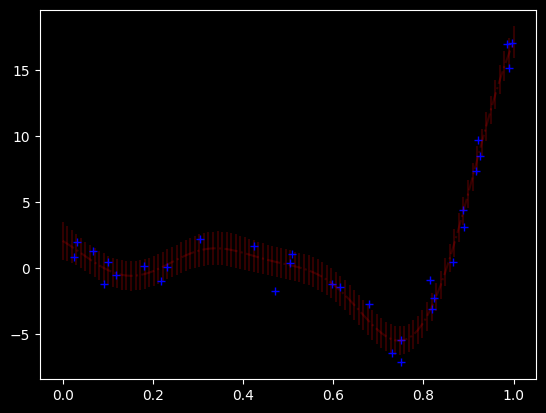

In [16]:
train_adam(xtr, ytr, log_length_scale, log_scale, log_beta, 50, 0.1)
with torch.no_grad():
    ypred, yvar = forward(xtr, xte, log_length_scale, log_scale, log_beta, ytr)
    
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()